# 프로젝트: ResNet Ablation Study

In [5]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [7]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [8]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [9]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## ResNet 기본 블록 구성하기

In [12]:
def build_resnet(input_shape=(32,32,3),is_50 = False, num_classes=10):

    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]
    num_classes = num_classes

    input_layer = Input(shape=input_shape, dtype='float32', name='input')  # input layer를 만들어둡니다.

    x = input_layer
    x = ZeroPadding2D(padding=(3, 3))(x)

    # conv1 layer
    x = Conv2D(
            filters=64,
            kernel_size=(7,7),
            kernel_regularizer=keras.regularizers.l2(0.0001),
            strides = (2,2),
            name ='conv1'
        )(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    # conv_2 layer with maxpool
    x = MaxPooling2D(
            pool_size=(3, 3),
            strides=2,
            name=f'conv2_max_pool'
        )(x)

    # Build Resnet Block
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(
            input_layer = x,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            is_50 = is_50
        )

    x = GlobalAveragePooling2D(name=f'average_pool')(x)
    output = keras.layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l2(0.0001), activation='softmax', name='fc')(x)

    model = keras.Model(
        inputs = input_layer,
        outputs = output
    )

    return model


In [13]:
# function for building VGG Block

# block_num : 블록 이름 붙이기 위해
# is_50 ResNet-50인지 구분하기 위해
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1, is_50=False):
    x = input_layer
    x_shortcut = x

    if is_50:
        x = build_resnet_50_block(x, num_cnn, channel, block_num)

    else:
        x = build_resnet_34_block(x, num_cnn, channel, block_num)
    return x

def build_resnet_50_block(x, num_cnn, channel, block_num):
    x_shortcut = x #항상 초기화
    for cnn_num in range(num_cnn):
#         print('========== ResNet-50 Block_{}_{} =============='.format(block_num,cnn_num))
        strides = (1,1)
        # 첫 번째 블록의 첫 번째 conv layer만 stides (1,1)이고 나머지 블록의 첫 번째 conv layer 는 (2,2)임.
        if cnn_num == 0 and block_num != 0:
            strides = (2,2)

            x = Conv2D(filters = channel, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001), strides= strides, padding='valid', name=f'block_{block_num}_1x1_{cnn_num}_1')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_1')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel, kernel_size = (3,3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='same',  name=f'block_{block_num}_conv_{cnn_num}')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_2')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel*4, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='valid', name=f'block_{block_num}_1x1_{cnn_num}_2')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_3')(x)

            # 각 블록의 첫 번째 conv layer 인 경우, shortcut 모양 맞춰주기
            if cnn_num == 0:

                x_shortcut = Conv2D(filters = channel*4, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001),strides=strides, padding='valid')(x_shortcut)
                x_shortcut = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_shortcut')(x_shortcut)

            x = Add()([x, x_shortcut])
            x = Activation('relu')(x)

            x_shortcut = x
    return x

def build_resnet_34_block(x, num_cnn, channel, block_num):
    x_shortcut = x #항상 초기화
    for cnn_num in range(num_cnn):
#         print('========== ResNet-34 Block_{}_{} =============='.format(block_num,cnn_num))
        strides = (1,1)
        # 첫 번째 블록의 첫 번째 conv layer만 stides (1,1)이고 나머지 블록의 첫 번째 conv layer 는(2,2)임.
        if cnn_num == 0 and block_num != 0:
            strides = (2,2)

            x = Conv2D(filters = channel, kernel_size = (3, 3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= strides, padding='same', name=f'block_{block_num}_conv_{cnn_num}_1')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_1')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel, kernel_size = (3,3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='same',  name=f'block_{block_num}_conv_{cnn_num}_2')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_2')(x)

            # 각 블록의 첫 번째 conv layer 인 경우, shortcut 모양 맞춰주기
            if cnn_num == 0:

                x_shortcut = Conv2D(filters = channel, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001),strides=strides, padding='valid')(x_shortcut)
                x_shortcut = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_shortcut')(x_shortcut)
            x = keras.layers.Add()([x,x_shortcut])
            x = keras.layers.Activation('relu')(x)

            x_shortcut = x

    return x

## ResNet-34, ResNet-50 Complete Model

In [14]:
# cifar-10 을 대상으로 하는 모델
resnet_34_cifar10 = build_resnet(input_shape=(32,32,3),is_50 = False, num_classes=10)
resnet_34_cifar10.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [15]:
# cifar-10 을 대상으로 하는 모델
resnet_50_cifar10 = build_resnet(input_shape=(32,32,3),is_50 = True, num_classes=10)
resnet_50_cifar10.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

## 일반 네트워크(plain network) 만들기

In [16]:
# function for building VGG Block

# block_num : 블록 이름 붙이기 위해
# is_50 ResNet-50인지 구분하기 위해
def build_plain_block(input_layer, num_cnn=3, channel=64, block_num=1, is_50=False):
    x = input_layer
    x_shortcut = x

    if is_50:
        x = build_resnet_50_block(x, num_cnn, channel, block_num)

    else:
        x = build_resnet_34_block(x, num_cnn, channel, block_num)
    return x

def build_plain_50_block(x, num_cnn, channel, block_num):
    x_shortcut = x #항상 초기화
    for cnn_num in range(num_cnn):
        print('========== Plain-50 Block_{}_{} =============='.format(block_num,cnn_num))
        strides = (1,1)
        # 첫 번째 블록의 첫 번째 conv layer만 stides (1,1)이고 나머지 블록의 첫 번째 conv layer 는 (2,2)임.
        if cnn_num == 0 and block_num != 0:
            strides = (2,2)

            x = Conv2D(filters = channel, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001), strides= strides, padding='valid', name=f'block_{block_num}_1x1_{cnn_num}_1')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_1')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel, kernel_size = (3,3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='same',  name=f'block_{block_num}_conv_{cnn_num}')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_2')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel*4, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='valid', name=f'block_{block_num}_1x1_{cnn_num}_2')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_3')(x)

            # 각 블록의 첫 번째 conv layer 인 경우, shortcut 모양 맞춰주기
            if cnn_num == 0:

                x_shortcut = Conv2D(filters = channel*4, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001),strides=strides, padding='valid')(x_shortcut)
                x_shortcut = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_shortcut')(x_shortcut)

            x_shortcut = x
    return x

def build_plain_34_block(x, num_cnn, channel, block_num):
    x_shortcut = x #항상 초기화
    for cnn_num in range(num_cnn):
        print('========== Plain-34 Block_{}_{} =============='.format(block_num,cnn_num))
        strides = (1,1)
        # 첫 번째 블록의 첫 번째 conv layer만 stides (1,1)이고 나머지 블록의 첫 번째 conv layer 는(2,2)임.
        if cnn_num == 0 and block_num != 0:
            strides = (2,2)

            x = Conv2D(filters = channel, kernel_size = (3, 3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= strides, padding='same', name=f'block_{block_num}_conv_{cnn_num}_1')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_1')(x)
            x = Activation('relu')(x)

            x = Conv2D(filters = channel, kernel_size = (3,3), kernel_regularizer=keras.regularizers.l2(0.0001), strides= (1,1), padding='same',  name=f'block_{block_num}_conv_{cnn_num}_2')(x)
            x = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_2')(x)

            # 각 블록의 첫 번째 conv layer 인 경우, shortcut 모양 맞춰주기
            if cnn_num == 0:

                x_shortcut = Conv2D(filters = channel, kernel_size = (1, 1), kernel_regularizer=keras.regularizers.l2(0.0001),strides=strides, padding='valid')(x_shortcut)
                x_shortcut = BatchNormalization(name=f'block_{block_num}_{cnn_num}_bn_shortcut')(x_shortcut)

            x_shortcut = x

    return x

In [17]:
def build_plain(input_shape=(32,32,3),is_50 = False, num_classes=1000):

    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]
    num_classes = num_classes

    input_layer = Input(shape=input_shape, dtype='float32', name='input')  # input layer를 만들어둡니다.

    x = input_layer

    # conv_1 layer
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(
            filters=64,
            kernel_size=(7,7),
            kernel_regularizer=keras.regularizers.l2(0.0001),
            strides = (2,2),
            name ='conv1'
        )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    # conv_2 layer maxpool 먼저
    x = MaxPooling2D(
            pool_size=(3, 3),
            strides=2,
            name=f'conv2_max_pool'
        )(x)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(
            input_layer = x,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            is_50 = is_50
        )

    x = GlobalAveragePooling2D(name=f'average_pool')(x)
    output = keras.layers.Dense(num_classes, kernel_regularizer=keras.regularizers.l2(0.0001), activation='softmax', name='fc')(x)
    model = keras.Model(
        inputs = input_layer,
        outputs = output
    )

    return model


In [18]:
# cifar-10 을 위한 모델
plain_34_cifar10 = build_plain(input_shape=(32,32,3),is_50 = False, num_classes=10)
plain_34_cifar10.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [19]:
plain_50_cifar10 = build_plain(input_shape=(32,32,3),is_50 = True, num_classes=10)
plain_50_cifar10.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

## ResNet-34 vs Plain-34, ResNet-50 vs Plain-50  _ cifar10 _ input_shape : (32,32,3)


We use SGD with a mini-batch size of 256. The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60×10^4 iterations.
We use a weight decay of 0.0001 and a momentum of 0.9

60×10^4 iterations 부분은 자원이 한정되어있어 하지 못했다.

In [20]:
BATCH_SIZE = 256
EPOCH = 10

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [22]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.1)

### Resnet-34 vs Plain-34 (cifar-10)

In [24]:
resnet_34_cifar10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.9),
    metrics=['accuracy'],
)

histort_resnet_34_cifar10 = resnet_34_cifar10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    #use_multiprocessing=True,
    callbacks = [reduce_lr]
)

Epoch 1/10
195/195 [==============================] - 16s 55ms/step - loss: 2.0209 - accuracy: 0.4297 - val_loss: 1.9830 - val_accuracy: 0.4068
Epoch 2/10
195/195 [==============================] - 8s 44ms/step - loss: 1.4383 - accuracy: 0.5850 - val_loss: 1.6155 - val_accuracy: 0.5297
Epoch 3/10
195/195 [==============================] - 9s 44ms/step - loss: 1.2196 - accuracy: 0.6631 - val_loss: 1.3139 - val_accuracy: 0.6352
Epoch 4/10
195/195 [==============================] - 8s 44ms/step - loss: 1.0632 - accuracy: 0.7211 - val_loss: 1.5457 - val_accuracy: 0.5658
Epoch 5/10
195/195 [==============================] - 9s 44ms/step - loss: 0.9730 - accuracy: 0.7523 - val_loss: 1.3203 - val_accuracy: 0.6526
Epoch 6/10
195/195 [==============================] - 8s 44ms/step - loss: 0.8716 - accuracy: 0.7880 - val_loss: 1.2224 - val_accuracy: 0.6784
Epoch 7/10
195/195 [==============================] - 9s 44ms/step - loss: 0.7777 - accuracy: 0.8206 - val_loss: 1.5699 - val_accuracy: 0.602

In [25]:
plain_34_cifar10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.9),
    metrics=['accuracy'],
)

histort_plain_34_cifar10 = plain_34_cifar10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [reduce_lr]
)

Epoch 1/10
195/195 [==============================] - 14s 45ms/step - loss: 2.0847 - accuracy: 0.4091 - val_loss: 2.1653 - val_accuracy: 0.3938
Epoch 2/10
195/195 [==============================] - 9s 45ms/step - loss: 1.5070 - accuracy: 0.5630 - val_loss: 1.6344 - val_accuracy: 0.5206
Epoch 3/10
195/195 [==============================] - 9s 45ms/step - loss: 1.3115 - accuracy: 0.6330 - val_loss: 1.5043 - val_accuracy: 0.5761
Epoch 4/10
195/195 [==============================] - 9s 44ms/step - loss: 1.1484 - accuracy: 0.6882 - val_loss: 1.4263 - val_accuracy: 0.5965
Epoch 5/10
195/195 [==============================] - 9s 44ms/step - loss: 1.0205 - accuracy: 0.7369 - val_loss: 1.4702 - val_accuracy: 0.5927
Epoch 6/10
195/195 [==============================] - 8s 43ms/step - loss: 0.9306 - accuracy: 0.7658 - val_loss: 1.3444 - val_accuracy: 0.6325
Epoch 7/10
195/195 [==============================] - 8s 43ms/step - loss: 0.8375 - accuracy: 0.7992 - val_loss: 1.4783 - val_accuracy: 0.622

## cifar-10 에 대한 resnet-34 vs plain-34 훈련 결과 비교

### training loss

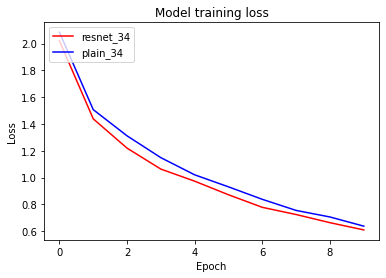

In [26]:
plt.plot(histort_resnet_34_cifar10.history['loss'], 'r')
plt.plot(histort_plain_34_cifar10.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

### validation accuracy

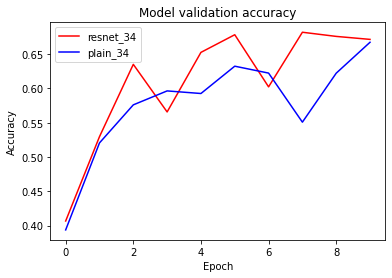

In [27]:
plt.plot(histort_resnet_34_cifar10.history['val_accuracy'], 'r')
plt.plot(histort_plain_34_cifar10.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

### 결과
Resnet이 Plain 비해 조금 더 성능을 보여주는 것을 알 수 있다. 시간관계상 에포크 수를 10으로밖에 못함. 20일때는 성능이 더 좋았었음.

### Resnet-50 vs Plain-50 (cifar-10) 훈련

In [28]:
resnet_50_cifar10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.9),
    metrics=['accuracy'],
)

histort_resnet_50_cifar10 = resnet_50_cifar10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [reduce_lr]
)

Epoch 1/10
195/195 [==============================] - 17s 56ms/step - loss: 4.5281 - accuracy: 0.2706 - val_loss: 13.6404 - val_accuracy: 0.2236
Epoch 2/10
195/195 [==============================] - 10s 51ms/step - loss: 2.5851 - accuracy: 0.4221 - val_loss: 3.2929 - val_accuracy: 0.2575
Epoch 3/10
195/195 [==============================] - 10s 51ms/step - loss: 2.3171 - accuracy: 0.4805 - val_loss: 2.6233 - val_accuracy: 0.3807
Epoch 4/10
195/195 [==============================] - 10s 51ms/step - loss: 2.1397 - accuracy: 0.5249 - val_loss: 2.3955 - val_accuracy: 0.4388
Epoch 5/10
195/195 [==============================] - 10s 51ms/step - loss: 1.9855 - accuracy: 0.5657 - val_loss: 2.0987 - val_accuracy: 0.5191
Epoch 6/10
195/195 [==============================] - 10s 51ms/step - loss: 1.8538 - accuracy: 0.5992 - val_loss: 2.0011 - val_accuracy: 0.5464
Epoch 7/10
195/195 [==============================] - 10s 51ms/step - loss: 1.7268 - accuracy: 0.6289 - val_loss: 2.5837 - val_accuracy

In [29]:
plain_50_cifar10.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.9),
    metrics=['accuracy'],
)

histort_plain_50_cifar10 = plain_50_cifar10.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [reduce_lr]
)

Epoch 1/10
195/195 [==============================] - 16s 53ms/step - loss: 4.0466 - accuracy: 0.2700 - val_loss: 3.5970 - val_accuracy: 0.1884
Epoch 2/10
195/195 [==============================] - 10s 51ms/step - loss: 2.4618 - accuracy: 0.4093 - val_loss: 2.5571 - val_accuracy: 0.3596
Epoch 3/10
195/195 [==============================] - 10s 51ms/step - loss: 2.2022 - accuracy: 0.4843 - val_loss: 2.2276 - val_accuracy: 0.4650
Epoch 4/10
195/195 [==============================] - 10s 52ms/step - loss: 2.0197 - accuracy: 0.5383 - val_loss: 2.1001 - val_accuracy: 0.5021
Epoch 5/10
195/195 [==============================] - 10s 52ms/step - loss: 1.8511 - accuracy: 0.5842 - val_loss: 2.1343 - val_accuracy: 0.4915
Epoch 6/10
195/195 [==============================] - 10s 51ms/step - loss: 1.7270 - accuracy: 0.6159 - val_loss: 1.8802 - val_accuracy: 0.5626
Epoch 7/10
195/195 [==============================] - 10s 52ms/step - loss: 1.5957 - accuracy: 0.6536 - val_loss: 1.9671 - val_accuracy:

## cifar-10 에 대한 resnet-50, plain-50 훈련 결과 비교

### training loss

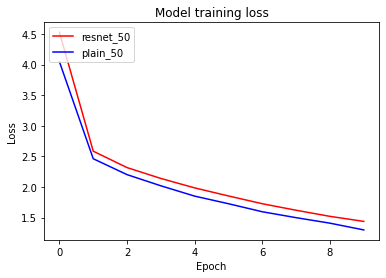

In [30]:
plt.plot(histort_resnet_50_cifar10.history['loss'], 'r')
plt.plot(histort_plain_50_cifar10.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

### validation accuracy

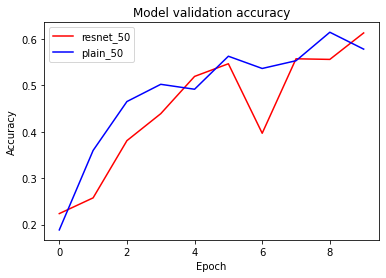

In [31]:
plt.plot(histort_resnet_50_cifar10.history['val_accuracy'], 'r')
plt.plot(histort_plain_50_cifar10.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

### 결과

Resnet34 vs Plain34와 마찬가지로, Resnet50이 나은 성능을 보인다.

## input_shape (224,224,3) 으로 비교해보기 : cats vs dogs 로 비교해보기

batch_size = 256 으로는 동작이 멈춰서, 확 낮춰서 32 로 하니 되길래, 32로 진행함

In [32]:
!pip install --upgrade tensorflow-datasets

In [33]:
BATCH_SIZE = 32
EPOCH = 10

In [34]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [35]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [36]:
# URL 업데이트
setattr(
    tfds.image_classification.cats_vs_dogs,
    '_URL',
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
)

# 데이터셋 다운로드
ds_cat_dog, ds_info_cat_dog = tfds.load(
    'cats_vs_dogs',
    split=['train'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)
# data_dir = '~/tensorflow_datasets'  # 데이터셋을 저장한 경로
# ds_cat_dog, ds_info_cat_dog = tfds.load(
#     'cats_vs_dogs',
#     split=['train'],
#     as_supervised=True,
#     shuffle_files=True,
#     with_info=True,
#     data_dir=data_dir
# )
# ds_cat_dog = ds_cat_dog[0]

In [37]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info_cat_dog.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [38]:
# 리스트에서 데이터셋 추출
ds_cat_dog = ds_cat_dog[0]  # 첫 번째 요소 추출

# 훈련 및 테스트 데이터셋 분할
TRAIN_SIZE = int(ds_info_cat_dog.splits['train'].num_examples * 0.8)
TEST_SIZE = int(ds_info_cat_dog.splits['train'].num_examples * 0.2)

ds_train_cat_dog = ds_cat_dog.take(TRAIN_SIZE)
ds_test_cat_dog = ds_cat_dog.skip(TRAIN_SIZE).take(TEST_SIZE)

# 데이터 확인
print("훈련 데이터셋 크기:", TRAIN_SIZE)
print("테스트 데이터셋 크기:", TEST_SIZE)


# TRAIN_SIZE = int(ds_info_cat_dog.splits['train'].num_examples*0.8)
# TEST_SIZE = int(ds_info_cat_dog.splits['train'].num_examples*0.2)

# ds_train_cat_dog = ds_cat_dog.take(TRAIN_SIZE)
# ds_test_cat_dog = ds_cat_dog.skip(TRAIN_SIZE)
# ds_test_cat_dog = ds_test_cat_dog.take(TEST_SIZE)

# # ds_cat_dog = pd.DataFrame(ds_cat_dog[0])
# # ds_cat_dog.shape



훈련 데이터셋 크기: 18609
테스트 데이터셋 크기: 4652


In [39]:
# msk = np.random.rand(ds_cat_dog.shape[0]) < 0.8
# ds_train_cat_dog = ds_cat_dog[msk]
# ds_test_cat_dog = ds_cat_dog[~msk]

ds_train_cat_dog = apply_normalize_on_dataset(ds_train_cat_dog, batch_size=BATCH_SIZE)
ds_test_cat_dog = apply_normalize_on_dataset(ds_test_cat_dog, batch_size=BATCH_SIZE)

In [40]:
ds_train_cat_dog

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [41]:
ds_test_cat_dog

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [42]:
cat_dog_input_shape = (224, 224, 3)
cat_dog_num_classes = 2

In [43]:
# cats_vs_dogs 을 대상으로 하는 모델
resnet_50_cat_dog = build_resnet(input_shape=cat_dog_input_shape,is_50 = True, num_classes=cat_dog_num_classes)
resnet_50_cat_dog.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [44]:
# cats_vs_dogs 을 대상으로 하는 모델
plain_50_cat_dog = build_plain(input_shape=cat_dog_input_shape,is_50 = True, num_classes=cat_dog_num_classes)
plain_50_cat_dog.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

cats_dogs 데이터셋, Resnet-50 모델에 적용

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

# ResNet-50 모델 로드 (사전 학습된 가중치 사용)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# 모델의 출력 가져오기
x = base_model.output

# 추가 레이어 (Flatten 후 Dense 레이어)
x = Flatten()(x)  # 특성을 1D로 변환
x = Dense(1, activation='sigmoid')(x)  # 출력 레이어 수정 (1개의 뉴런, sigmoid 활성화)

# 새로운 모델 생성
model = Model(inputs=base_model.input, outputs=x)

# 모델 컴파일
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=['accuracy']
)

# 모델 학습
history = model.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train'].num_examples * 0.8 / BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train'].num_examples * 0.2 / BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[reduce_lr]
)

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf

# ResNet-50 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# 커스텀 출력 레이어 추가
x = base_model.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

# 최종 모델 생성
model = Model(inputs=base_model.input, outputs=x)

# 모델 컴파일
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=['accuracy']
)

# 데이터셋 분리 (이미 정의된 ds_train_cat_dog, ds_test_cat_dog 사용)
history = model.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train'].num_examples * 0.8 / BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train'].num_examples * 0.2 / BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[reduce_lr]
)

Epoch 1/10
 22/581 [>.............................] - ETA: 3:02 - loss: 195.1524 - accuracy: 0.4915

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 58/581 [=>............................] - ETA: 2:46 - loss: 90.1066 - accuracy: 0.4822

 68/581 [==>...........................] - ETA: 2:42 - loss: 78.6523 - accuracy: 0.4835

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:26 - loss: 47.8782 - accuracy: 0.4926

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


162/581 [=======>......................] - ETA: 2:11 - loss: 33.9047 - accuracy: 0.4950

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


165/581 [=======>......................] - ETA: 2:10 - loss: 33.3012 - accuracy: 0.4977

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


179/581 [========>.....................] - ETA: 2:06 - loss: 30.7505 - accuracy: 0.4986

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:16 - loss: 16.6247 - accuracy: 0.5015

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 9.9642 - accuracy: 0.4978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0x

581/581 [==============================] - 246s 391ms/step - loss: 9.9642 - accuracy: 0.4978 - val_loss: 0.6964 - val_accuracy: 0.5056
Epoch 2/10
 23/581 [>.............................] - ETA: 2:53 - loss: 0.7161 - accuracy: 0.4796

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 60/581 [==>...........................] - ETA: 2:41 - loss: 0.7041 - accuracy: 0.5026

 74/581 [==>...........................] - ETA: 2:37 - loss: 0.7019 - accuracy: 0.5004

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:25 - loss: 0.6998 - accuracy: 0.5019

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


164/581 [=======>......................] - ETA: 2:10 - loss: 0.6993 - accuracy: 0.5006

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


170/581 [=======>......................] - ETA: 2:08 - loss: 0.6997 - accuracy: 0.4998

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


183/581 [========>.....................] - ETA: 2:04 - loss: 0.6994 - accuracy: 0.4995

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


225/581 [==========>...................] - ETA: 1:50 - loss: 0.6984 - accuracy: 0.5013

In [ ]:
plain_50_cat_dog.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.9),
    metrics=['accuracy'],
)

histort_plain_50_cat_dog = plain_50_cat_dog.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train'].num_examples*0.8/BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train'].num_examples*0.2/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [reduce_lr]
)

### training loss

In [ ]:
plt.plot(histort_resnet_50_cat_dog.history['loss'], 'r')
plt.plot(histort_plain_50_cat_dog.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

### validation accuracy

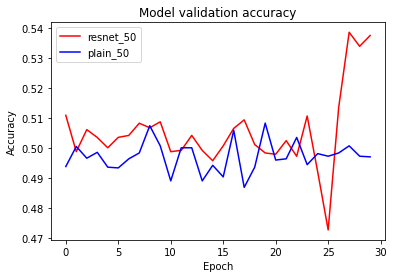

In [ ]:
plt.plot(histort_resnet_50_cat_dog.history['val_accuracy'], 'r')
plt.plot(histort_plain_50_cat_dog.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

### 비교 결과
이 데이터셋에 대해서 loss는 오히려 더 높았고, accuracy는 근소하게 더 높았다.

### 회고
추후 적절한 모델을 위한 Learning Rate, Acciracy, Loss 등등을 최적화할수 있도록 Optimizer Platform등을 조사하고 참조하야겠다.